 # Machine Learning LAB 1
 Academic Year 2021/22, P. Zanuttigh, U. Michieli, F. Barbato, D. Shenaj, G. Rizzoli

The notebook contains some simple tasks to be performed about classification and regression.

**Student name**: Dario Massa<br>
**ID Number**: 2039311


# 1) Classification of Music genre

### Dataset description

A music genre is a conventional category that identifies pieces of music as belonging to a shared tradition or set of conventions. It is to be distinguished from musical form and musical style. The features extracted from these songs can help the machine to assing them to the two genres. 

This dataset is a subset of the dataset provided [here](https://www.kaggle.com/insiyeah/musicfeatures), containing only the data regarding the classical and metal genres.

### We consider 3 features for the classification

1) **tempo**, the speed at which a passage of music is played, i.e., the beats per minute of the musical piece<br>
2) **chroma_stft**, [mean chromagram activation on Short-Time Fourier Transform](https://librosa.org/doc/0.7.0/generated/librosa.feature.chroma_stft.html)<br>
3) **spectral_centroid**, Indicates where the "center of mass" of the spectrum is located, i.e., it is the weighted average of the frequency transform<br>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os

import numpy as np
import scipy as sp
import sklearn as sl
import pandas as pd
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

from pandas.plotting import scatter_matrix

## PERCEPTRON

In [2]:
IDnumber = 2039311 


**Loading the dataset**


In [3]:
PATH = "./data"

def load_data(path=PATH):
    csv_path = os.path.join(path, "music.csv")
    return pd.read_csv(csv_path) 

music=load_data()

music.label= 2*music.label-1     # for the perceptron classical--> -1, metal-->1


**Let us have a look to it in multiple ways**


In [4]:
music.head()

,tempo,chroma_stft,spectral_centroid,label
0,92.285156,0.223738,2192.798091,-1
1,161.499023,0.284173,1534.064978,-1
2,143.554688,0.208113,1396.824265,-1
3,95.703125,0.312900,1680.088264,-1
4,123.046875,0.258572,1173.658308,-1


In [5]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tempo              200 non-null    float64
 1   chroma_stft        200 non-null    float64
 2   spectral_centroid  200 non-null    float64
 3   label              200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


In [6]:
music.describe()

,tempo,chroma_stft,spectral_centroid,label
count,200.000000,200.000000,200.000000,200.000000
mean,126.321578,0.371369,1978.083397,0.000000
std,29.336878,0.118268,720.685022,1.002509
min,61.523438,0.181161,690.075902,-1.000000
25%,103.359375,0.261238,1347.129607,-1.000000
50%,123.046875,0.379629,2008.928539,0.000000
75%,143.554688,0.477488,2683.416292,1.000000
max,234.907670,0.636205,3403.101905,1.000000


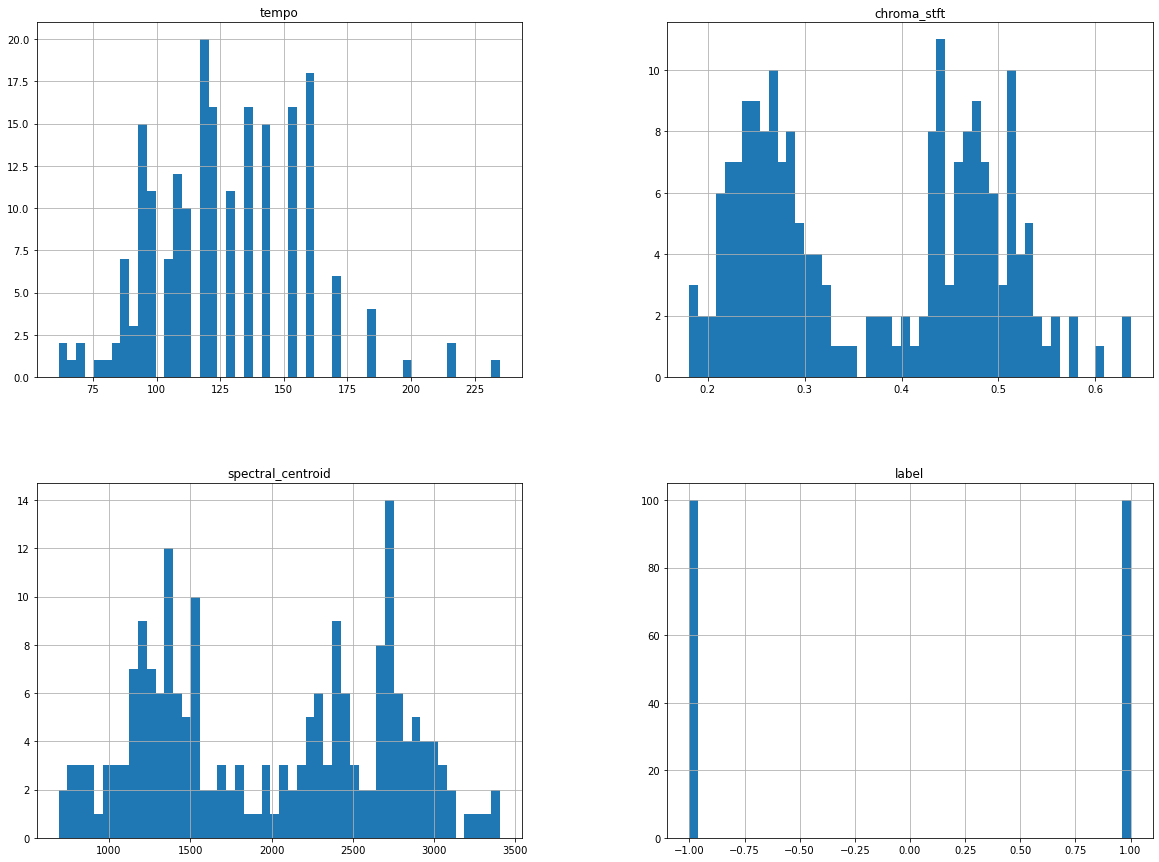

In [7]:
music.hist(bins=50, figsize=(20,15))
plt.show()

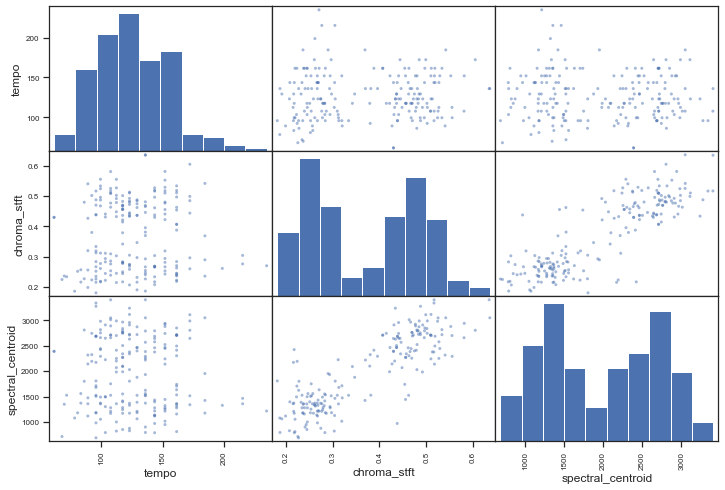

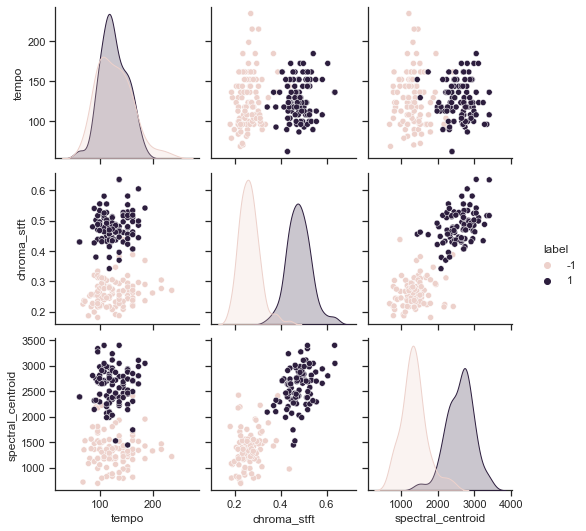

In [8]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

attributes = ["tempo","chroma_stft","spectral_centroid"]

scatter_matrix(music[attributes], figsize=(12, 8))

sns.pairplot(music, hue="label")

**From these plots I can already visually quantify the separation/overlap between the involved variables. Tempo displays strong overlap**

Let's split in **training** and **test** sets

In [9]:
def splitter(totalset, percentage): 
    
    np.random.seed(2039311)
    shuffling = np.random.permutation(len(totalset)) 
    
    test_set_size = int(len(totalset) * percentage) 
    
    test_indices = shuffling[:test_set_size]     
    train_indices = shuffling[test_set_size:] 
    
    return totalset.iloc[train_indices], totalset.iloc[test_indices]

train_set, test_set = splitter(music, 0.25)

print("Here's the length of the training set:",len(train_set))
print("Here's the length of the test set:",len(test_set))
print("\nNumber of classical instances in test:", np.sum(test_set.label==-1))
print("Number of metal instances in test:", np.sum(test_set.label==1))

print("Shape of training set: " + str(train_set.shape))
print("Shape of test set: " + str(test_set.shape))

Here's the length of the training set: 150
Here's the length of the test set: 50

Number of classical instances in test: 20
Number of metal instances in test: 30
Shape of training set: (150, 4)
Shape of test set: (50, 4)


In [10]:
# Add a 1 to each sample (homogeneous coordinates)
train_set = np.hstack((np.ones((len(train_set),1)),train_set))
test_set = np.hstack((np.ones((len(test_set),1)),test_set))

In [11]:
print("Training set in homogeneous coordinates:")
print(train_set[:4])

Training set in homogeneous coordinates:
[[ 1.00000000e+00  1.43554688e+02  2.34085778e-01  1.27961458e+03
  -1.00000000e+00]
 [ 1.00000000e+00  1.43554688e+02  2.17626991e-01  7.89601607e+02
  -1.00000000e+00]
 [ 1.00000000e+00  1.43554688e+02  2.67353394e-01  1.11822751e+03
  -1.00000000e+00]
 [ 1.00000000e+00  9.93840144e+01  2.61489298e-01  1.37282581e+03
  -1.00000000e+00]]


**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where one iteration corresponds to one update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of misclassified samples for the best model

In [12]:
X = train_set[:,:-1]
X.shape

(150, 4)

In [13]:
Y = train_set[:,-1:]
Y.shape

(150, 1)

In [14]:
curr_w = np.zeros(4)
curr_w.shape

(4,)

In [15]:
def perceptron_search(current_w, x, y):
    
    if ( y*np.dot(current_w,x) ) <= 0.0:
        
        miscl = 1 
    
    else: 
        
        miscl = 0
    
    return miscl

def perceptron_update(current_w, x, y):
    
    if ( y*np.dot(x,current_w) ) <= 0.0:
        
        new_w = current_w + x*y

        return new_w
    
    else: 
        
        return current_w
    
def perceptron_test(best_w, X, Y):

    num_samples = len(X)
    index_misclassified = []
    num_misclassified = 0 
    
    for i in range(num_samples):

        x = X[i,:]
        y = Y[i,:]

        misclassified = perceptron_search(best_w,x,y)

        if (misclassified == 1):

            index_misclassified = np.append(index_misclassified,i)  
            num_misclassified += 1 


    error = num_misclassified 

    error_percent = (error / num_samples)*100
    
    return error_percent

def perceptron(X, Y, max_num_iterations):
    
    curr_w = np.zeros(4) # considering also the dummy 1 variable of homog. coord.s

    best_w = curr_w
    num_samples = len(X)

    num_iter = 1
    
    error=150 #fake
    best_error=0

    vector_best_errors=[]
    vector_best_solutions=[]
    vector_best_iter = []
    
    while ((error==0) or (num_iter < max_num_iterations)):
        
        index_misclassified = []
        num_misclassified = 0 

    # first I want to find out which and how many indexes are misclassified 
    # how many indexes are misclassified is the current error
    
        #old_error = error
        #old_w = curr_w
      
        
        for i in range(num_samples):
        
            x = X[i,:]
            y = Y[i,:]
    
            misclassified = perceptron_search(curr_w,x,y)

            if (misclassified == 1):

                index_misclassified = np.append(index_misclassified,i)  
                num_misclassified += 1 
        
        
        error = num_misclassified 
        
        error_percent = (error / num_samples)*100
        
        if error_percent < 50.0:
            
            vector_best_errors = np.append(vector_best_errors,error)
            vector_best_solutions = np.append(vector_best_solutions,curr_w)
            vector_best_iter = np.append(vector_best_iter,num_iter)
            
        #print("-------")
        #print("PERCEPTRON ALGORITHM")
        #print("-------")
        #print("")
        #print("Here follow the misclassified samples indexes:",index_misclassified)
        #print("")
        #print("and the current error:", error)
        #print("")
        
        # second, I shuffle over these indexes and select the corresponding random missclassified sample 
        
        shuffling = np.random.permutation(index_misclassified) 
        #print(shuffling)
        rand = int(shuffling[4])
 
        #print("")
        #print("random choice:",rand)
        #print("")
        #print("")    
        
        x = X[rand,:]
        y = Y[rand,:]
                           
        # update rule of w 
        
        curr_w = perceptron_update(curr_w,x,y)
        
        num_iter += 1
    
        #print("")
        #print("resulting coordinates vector:",curr_w)
        #print("")
        #print("number of iter:",num_iter)    
    
#    best_error = error
    
    return best_w, best_error, vector_best_solutions, vector_best_errors, vector_best_iter

**TO DO** use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [16]:
vector_best_errors=[]
vector_best_solutions=[]
vector_best_iter = []
num_iter = 100
best_w, best_error, vector_best_solutions, vector_best_errors, vector_best_iter = perceptron(X, Y, num_iter)

#print (best_w, best_error)
#print (vector_best_solutions,vector_best_errors, vector_best_iter)

best_index = np.where(vector_best_errors == vector_best_errors.min())
#best_index = np.asarray(best_index)
min_index = best_index[0]
#print (min_index[0])

print("-------")
print("END OF PERCEPTRON ALGORITHM")
print("-------")
print("The best solution has been obtained at iteration:", int(vector_best_iter[min_index[0]]),"of",num_iter)
print("-------")
print("with error and error%:", vector_best_errors[min_index[0]],100*(vector_best_errors[min_index[0]]/len(X)) )
print("-------")
print("and coefficients:", vector_best_solutions[4*min_index[0]],vector_best_solutions[4*min_index[0]+1],vector_best_solutions[4*min_index[0]+2],vector_best_solutions[4*min_index[0]+3])

-------
END OF PERCEPTRON ALGORITHM
-------
The best solution has been obtained at iteration: 84 of 100
-------
with error and error%: 52.0 34.66666666666667
-------
and coefficients: -25.0 -3516.4135482602464 -0.18229563526111975 417.868231019972


**EVALUATION OF PERFORMANCES: TEST SET**

In [17]:
best_solution=np.array([vector_best_solutions[4*min_index[0]],vector_best_solutions[4*min_index[0]+1],vector_best_solutions[4*min_index[0]+2],vector_best_solutions[4*min_index[0]+3]])
print(best_solution)

X = test_set[:,:-1]
print(X.shape)

Y = test_set[:,-1:]
print(Y.shape)

test_result = perceptron_test(best_solution,X,Y)

print("-------")
print("END OF TESTING OF PERCEPTRON ALGORITHM")
print("-------")
print("The best solution on test set brings error%:",test_result)


[-2.50000000e+01 -3.51641355e+03 -1.82295635e-01  4.17868231e+02]
(50, 4)
(50, 1)
-------
END OF TESTING OF PERCEPTRON ALGORITHM
-------
The best solution on test set brings error%: 34.0


**TO DO** **[Answer the following]** What about the difference betweeen the training error and the test error  in terms of fraction of misclassified samples)? Explain what you observe. [Write the answer in this cell]

**ANSWER QUESTION 1**
Since the number of iterations is too small, the training of the algorithm on the training set S is not sufficient in order to gain small training errors (i.e. <20%). Nevertheless, it is observed that the test error is very close. This close distancing could be explained with a clear absence of a proper training, which makes the training set less familiar to the algorithm, and therefore less dissimilar from a disjoint test set. 



**TO DO** Copy the code from the last 2 cells above in the cell below and repeat the training with 4000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [18]:
X = train_set[:,:-1]
print(X.shape)

Y = train_set[:,-1:]
print(Y.shape)

vector_best_errors=[]
vector_best_solutions=[]
vector_best_iter = []
num_iter = 4000
best_w, best_error, vector_best_solutions, vector_best_errors, vector_best_iter = perceptron(X, Y, num_iter)

#print (best_w, best_error)
#print (vector_best_solutions,vector_best_errors, vector_best_iter)

best_index = np.where(vector_best_errors == vector_best_errors.min())
#best_index = np.asarray(best_index)
min_index = best_index[0]
#print (min_index[0])

print("-------")
print("END OF PERCEPTRON ALGORITHM")
print("-------")
print("The best solution has been obtained at iteration:", int(vector_best_iter[min_index[0]]),"of",num_iter)
print("-------")
print("with error and error%:", vector_best_errors[min_index[0]],100*(vector_best_errors[min_index[0]]/len(X)) )
print("-------")
print("and coefficients:", vector_best_solutions[4*min_index[0]],vector_best_solutions[4*min_index[0]+1],vector_best_solutions[4*min_index[0]+2],vector_best_solutions[4*min_index[0]+3])

(150, 4)
(150, 1)
-------
END OF PERCEPTRON ALGORITHM
-------
The best solution has been obtained at iteration: 144 of 4000
-------
with error and error%: 16.0 10.666666666666668
-------
and coefficients: -47.0 -6449.71908179146 -1.8999067152083107 395.65478245492204


**EVALUATION OF PERFORMANCES: TEST SET**

In [19]:
best_solution=np.array([vector_best_solutions[4*min_index[0]],vector_best_solutions[4*min_index[0]+1],vector_best_solutions[4*min_index[0]+2],vector_best_solutions[4*min_index[0]+3]])
#print(best_solution)

X = test_set[:,:-1]
print(X.shape)

Y = test_set[:,-1:]
print(Y.shape)

test_result = perceptron_test(best_solution,X,Y)

print("-------")
print("END OF TESTING OF PERCEPTRON ALGORITHM")
print("-------")
print("The best solution on test set brings error%:",test_result)


(50, 4)
(50, 1)
-------
END OF TESTING OF PERCEPTRON ALGORITHM
-------
The best solution on test set brings error%: 16.0


**TO DO** [Answer the following] What about the difference betweeen the training error and the test error  in terms of fraction of misclassified samples) when running for a larger number of iterations ? Explain what you observe and compare with the previous case. [Write the answer in this cell]

**ANSWER QUESTION 2**

The performances on the test set have revealed a greater error, of 16.0% with respect to the 10.7% obtained in the training set. This was somehow an expected result: the algorithm is trained on the training set S, which is relatively small, in order to find the optimal solution (predictor, ERM solution) h_w_S, and of course lead to relatively smaller training errors L_s; however, the optimal predictor is such over S, and not over the whole domain; this is why the errors are expected to raise, and the disjointed test set is a way of challanging its generalization ability, obtaining an estimate of the true error L_D. Of course this is just an estimate, since the samples we are dealing with do not cover the full domain and we do not know the distribution D.
It should be noted that the distancing between the training and test error, in this case of 4000 iterations, is larger than the distancing in the 100 case. 
This is somehow a product of the fact that a longer training certainly can lead to lower training and test errors, but also to learn the data. Although " learning from the data " is often associated to overfitting, this is not the case since the model is characterized by the needed low complexity. What I suppose is happening is that the algorithm is properly learning the ERM solution with the right amount of iterations (a proof of that is the fact that multiple degenerate ERM solutions are found) and, as it is supposed to be, is learning the data shaping what it is used to and what it is not used to classify. If we underfit with an extremely low number of iterations, the difference between what is known and what is not known is more blurred, therefore L_s and L_D are nearer, but both higher.

# Logistic Regression
Now we use logistic regression, exploiting the implementation in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [20]:
PATH = "./data"

def load_data(path=PATH):
    csv_path = os.path.join(path, "music.csv")
    return pd.read_csv(csv_path) 

music=load_data()

music.label= 2*music.label-1     # for the perceptron classical--> -1, metal-->1

def splitter(totalset, percentage): 
    
    np.random.seed(2039311)
    shuffling = np.random.permutation(len(totalset)) 
    
    test_set_size = int(len(totalset) * percentage) 
    
    test_indices = shuffling[:test_set_size]     
    train_indices = shuffling[test_set_size:] 
    
    return totalset.iloc[train_indices], totalset.iloc[test_indices]

train_set, test_set = splitter(music, 0.25)

print("Here's the length of the training set:",len(train_set))
print("Here's the length of the test set:",len(test_set))
print("\nNumber of classical instances in test:", np.sum(test_set.label==-1))
print("Number of metal instances in test:", np.sum(test_set.label==1))

print("Shape of training set: " + str(train_set.shape))
print("Shape of test set: " + str(test_set.shape))

# Add a 1 to each sample (homogeneous coordinates)
train_set = np.hstack((np.ones((len(train_set),1)),train_set))
test_set = np.hstack((np.ones((len(test_set),1)),test_set))

Here's the length of the training set: 150
Here's the length of the test set: 50

Number of classical instances in test: 20
Number of metal instances in test: 30
Shape of training set: (150, 4)
Shape of test set: (50, 4)


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples misclassified in the training set and in the test set.

In [21]:
from sklearn import metrics

#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5,fit_intercept=True) #a large C disables regularization

#learn from training set

X = train_set[:,1:3]
print(X.shape)

Y = train_set[:,-1]
print(Y.shape)

logreg.fit(X,Y)

#predict on training set

y_pred_train=logreg.predict(X)

score = logreg.score(X,Y)

cnf_matrix = metrics.confusion_matrix(y_pred_train,Y)
print(cnf_matrix)

#print the error rate = fraction of misclassified samples
error_rate_training = 1-score

# PLACE YOUR CODE

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

X = test_set[:,1:3]
print(X.shape)

Y = test_set[:,-1]
print(Y.shape)

y_pred_test=logreg.predict(X)

cnf_matrix = metrics.confusion_matrix(y_pred_test,Y)
print(cnf_matrix)

score = logreg.score(X,Y.ravel())

#print(logreg.intercept_)
#print(logreg.coef_)

#print the error rate = fraction of misclassified samples
error_rate_test = 1-score

# PLACE YOUR CODE

print("Error rate on test set: " + str(error_rate_test))

(150, 2)
(150,)
[[78  2]
 [ 2 68]]
Error rate on training set: 0.026666666666666616
(50, 2)
(50,)
[[19  0]
 [ 1 30]]
Error rate on test set: 0.020000000000000018


**TO DO** Now pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test. Which features are you going to select ?

Basing on the scatter matrix plots in the upper part of this notebook, it is clear that the 'tempo' variable is a more negative feature in terms of the classification with respect to the others: when it is involved, the forming clusters tend to have a bit of overlap, and this could be due to the fact that the two genre of music can also share similar values of tempo (it is visible from the first plot in the matrix, an histogram of the tempo feature for the two genres). In the cases in which the other two features are involved instead, a nicer separation is achieved. Therefore 'chroma_stft', 'spectral_centroid' will be hereafter considered. 

In [22]:
X = train_set[:,2:3]
print(X.shape)

Y = train_set[:,-1]
print(Y.shape)

logreg.fit(X,Y)

#predict on training set

y_pred_train=logreg.predict(X)

score = logreg.score(X,Y)

cnf_matrix = metrics.confusion_matrix(y_pred_train,Y)
print(cnf_matrix)

#print the error rate = fraction of misclassified samples
error_rate_training = 1-score

# PLACE YOUR CODE

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

X = test_set[:,2:3]
print(X.shape)

Y = test_set[:,-1]
print(Y.shape)

y_pred_test=logreg.predict(X)

cnf_matrix = metrics.confusion_matrix(y_pred_test,Y)
print(cnf_matrix)

score = logreg.score(X,Y.ravel())

print(logreg.intercept_)
print(logreg.coef_)

#print the error rate = fraction of misclassified samples
error_rate_test = 1-score

# PLACE YOUR CODE

print("Error rate on test set: " + str(error_rate_test))

(150, 1)
(150,)
[[77  1]
 [ 3 69]]
Error rate on training set: 0.026666666666666616
(50, 1)
(50,)
[[19  0]
 [ 1 30]]
[-20.0183421]
[[54.47974105]]
Error rate on test set: 0.020000000000000018


**TO DO** [Answer the following] Which features did you select and why ? Compare the perfromances with the ones of the case with all the 3 features and comment about the results. [Write the answer in this cell]

**ANSWER QUESTION 3**
The first question has been answered in *ANSWER QUESTION 2*. The performances in the case of just 2 features considered are actually the same from the point of view of the error rate. With closer look, on the training set, when 3 features are considered the error is symmetrical (2 misclassified samples for each class), while becomes asymmetrical in the case of 2 features selected, although conserving the total error. In the test set instead nothing changes between the two cases. 

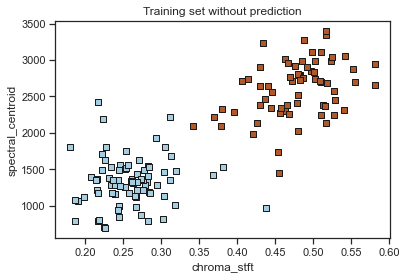

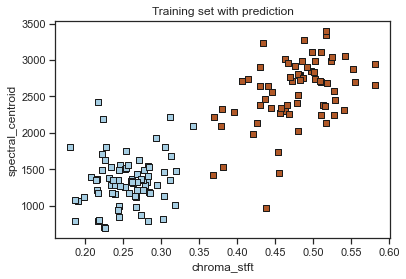

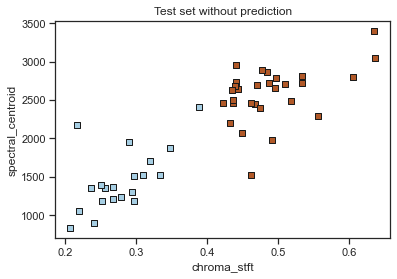

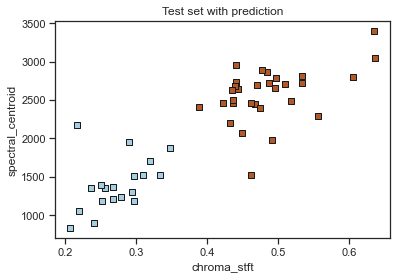

In [23]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

# NOTICE: This visualization code has been developed for a "standard" solution of the notebook, 
# it could be necessary to make some fixes to adapt to your implementation

#plt.pcolormesh(train_set[:, 2], train_set[:, 3], train_set[:, -1], cmap=plt.cm.Paired)

plt.scatter(train_set[:, 2], train_set[:, 3], c=train_set[:, -1], edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel("chroma_stft")
plt.ylabel("spectral_centroid")
plt.title('Training set without prediction')
plt.show()

plt.scatter(train_set[:, 2], train_set[:, 3], c=y_pred_train, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel("chroma_stft")
plt.ylabel("spectral_centroid")
plt.title('Training set with prediction')
plt.show()

plt.scatter(test_set[:, 2], test_set[:, 3], c=test_set[:, -1], edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel("chroma_stft")
plt.ylabel("spectral_centroid")
plt.title('Test set without prediction')
plt.show()

plt.scatter(test_set[:, 2], test_set[:, 3], c=y_pred_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel("chroma_stft")
plt.ylabel("spectral_centroid")
plt.title('Test set with prediction')
plt.show()


# 2) Linear Regression on the Boston House Price dataset

### Dataset description: 

The Boston House Price Dataset involves the prediction of a house price in thousands of dollars given details about the house and its neighborhood.

The dataset contains a total of 500 observations, which relate 13 input features to an output variable (house price).

The variable names are as follows:

CRIM: per capita crime rate by town.

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS: proportion of nonretail business acres per town.

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX: nitric oxides concentration (parts per 10 million).

RM: average number of rooms per dwelling.

AGE: proportion of owner-occupied units built prior to 1940.

DIS: weighted distances to five Boston employment centers.

RAD: index of accessibility to radial highways.

TAX: full-value property-tax rate per $10,000.

PTRATIO: pupil-teacher ratio by town.

B: 1000*(Bk – 0.63)2 where Bk is the proportion of blacks by town.

LSTAT: % lower status of the population.

MEDV: Median value of owner-occupied homes in $1000s.
    

**Importing the needed stuff**

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os

import numpy as np
import scipy as sp
import sklearn as sl
import pandas as pd
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

from pandas.plotting import scatter_matrix

PATH = "./data"

def load_data(path=PATH):
    csv_path = os.path.join(path, "house.csv")
    return pd.read_csv(csv_path, sep=';') 

house=load_data()



**Let's have a look to data in different ways**

In [25]:
house.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,240
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,216
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,347
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,334
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,362


In [26]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     500 non-null    float64
 1   ZN       500 non-null    float64
 2   INDUS    500 non-null    float64
 3   CHAS     500 non-null    int64  
 4   NOX      500 non-null    float64
 5   RM       500 non-null    float64
 6   AGE      500 non-null    float64
 7   DIS      500 non-null    float64
 8   RAD      500 non-null    int64  
 9   TAX      500 non-null    int64  
 10  PTRATIO  500 non-null    float64
 11  B        500 non-null    float64
 12  LSTAT    500 non-null    float64
 13  MEDV     500 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 54.8 KB


In [27]:
house.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.655786,11.500000,11.131740,0.070000,0.554451,6.282970,68.424600,3.811932,9.642000,409.624000,18.428600,356.208040,12.698740,225.680000
std,8.644375,23.428739,6.900712,0.255403,0.116550,0.705421,28.272145,2.112591,8.715604,168.998579,2.162553,91.741874,7.164928,92.357075
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,50.000000
25%,0.082598,0.000000,5.130000,0.000000,0.448750,5.883000,44.225000,2.087875,4.000000,281.000000,17.225000,375.085000,6.990000,170.750000
50%,0.266005,0.000000,9.125000,0.000000,0.538000,6.208500,77.150000,3.267450,5.000000,330.000000,19.000000,391.305000,11.430000,212.000000
75%,3.694070,12.500000,18.100000,0.000000,0.624000,6.620500,94.100000,5.214600,24.000000,666.000000,20.200000,396.157500,17.092500,250.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,500.000000


array([[<AxesSubplot:xlabel='CRIM', ylabel='CRIM'>,
        <AxesSubplot:xlabel='ZN', ylabel='CRIM'>,
        <AxesSubplot:xlabel='INDUS', ylabel='CRIM'>],
       [<AxesSubplot:xlabel='CRIM', ylabel='ZN'>,
        <AxesSubplot:xlabel='ZN', ylabel='ZN'>,
        <AxesSubplot:xlabel='INDUS', ylabel='ZN'>],
       [<AxesSubplot:xlabel='CRIM', ylabel='INDUS'>,
        <AxesSubplot:xlabel='ZN', ylabel='INDUS'>,
        <AxesSubplot:xlabel='INDUS', ylabel='INDUS'>]], dtype=object)

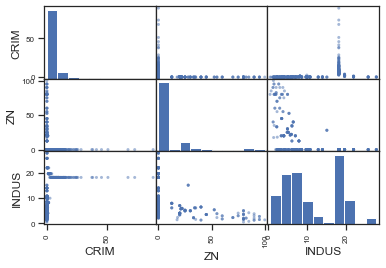

In [28]:
attributes = ["CRIM","ZN","INDUS"]

scatter_matrix(house[attributes], figsize=(6, 4))

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. For instance one can take $m_t=0.7m$ of the data as training and $m_{test}=0.3m$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training and test sets (70%-30%)

In [29]:
def splitter(totalset, percentage): 
    
    np.random.seed(2039311)
    shuffling = np.random.permutation(len(totalset)) 
    
    test_set_size = int(len(totalset) * percentage) 
    
    test_indices = shuffling[:test_set_size]     
    train_indices = shuffling[test_set_size:] 
    
    return totalset.iloc[train_indices], totalset.iloc[test_indices]

train_set, test_set = splitter(house, 0.30)

print("Here's the length of the training set:",len(train_set))
print("Here's the length of the test set:",len(test_set))

print("Shape of training set: " + str(train_set.shape))
print("Shape of test set: " + str(test_set.shape))


Here's the length of the training set: 350
Here's the length of the test set: 150
Shape of training set: (350, 14)
Shape of test set: (150, 14)


# Data Normalization
It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to 1. This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [30]:
# scale the data

# standardize the input matrix
from sklearn import preprocessing
# the transformation is computed on training data and then used on all the 3 sets

X_training = train_set.iloc[:,:-1]
print(X_training.shape)

X_test = test_set.iloc[:,:-1]
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

scaler = preprocessing.StandardScaler().fit(X_test) 

np.set_printoptions(suppress=True)
X_test = scaler.transform(X_test) # use the same transformation on test data
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

(350, 13)
(150, 13)
Mean of the training input data: [ 0.  0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.]
Std of the training input data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the test input data: [-0.  0.  0. -0. -0. -0.  0.  0. -0.  0.  0. -0. -0.]
Std of the test input data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.


 **TO DO:** compute the linear regression coefficients using np.linalg.lstsq from scikitlear 
 

In [31]:
#compute linear regression coefficients for training data

Y_training = train_set.iloc[:,-1]
print(Y_training.shape)
Y_training = Y_training.astype('float64')

#add a 1 at the beginning of each sample for training, and testing (use homogeneous coordinates)
m_training = X_training.shape[0]
X_trainingH = np.hstack((np.ones((m_training,1)),X_training)) # H: in homogeneous coordinates
print(X_trainingH.shape)
X_trainingH = X_trainingH.astype('float64')

Y_test = test_set.iloc[:,-1]
print(Y_test.shape)

m_test = X_test.shape[0]
X_testH = np.hstack((np.ones((m_test,1)),X_test))  # H: in homogeneous coordinates
print(X_testH.shape)

# Compute the least-squares coefficients using linalg.lstsq
w_np, RSStr_np, rank_Xtr, sv_Xtr = np.linalg.lstsq(X_trainingH, Y_training)
print("LS coefficients with numpy lstsq:", w_np)

w_np=np.transpose(w_np)
print(w_np.shape)

# compute Residual sums of squares 
res=( Y_training - np.dot(X_trainingH,w_np)  )
RSStr_hand = np.inner(res,res)

#print("RSS with numpy lstsq: ", RSStr_np)
print("Empirical risk with numpy lstsq:", RSStr_np/m_training)
print("Empirical risk by hand:", RSStr_hand/m_training)

(350,)
(350, 14)
(150,)
(150, 14)
LS coefficients with numpy lstsq: [224.11714286  -8.58379076  12.85328033   0.588573     7.83304354
 -19.37008294  25.16770822   3.70893909 -33.33105325  26.52166986
 -19.90007235 -19.25626074  10.0227184  -41.67719909]
(14,)
Empirical risk with numpy lstsq: [2260.65280665]
Empirical risk by hand: 2260.6528066483015


/var/folders/6w/m1m6tnk96lx6qjy4zz33q_wr0000gn/T/ipykernel_14801/1997044293.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_np, RSStr_np, rank_Xtr, sv_Xtr = np.linalg.lstsq(X_trainingH, Y_training)


## Data prediction 

Compute the output predictions on both training and test set and compute the Residual Sum of Squares (RSS). 

**TO DO**: Compute these quantities on  training and test sets.

In [32]:
#compute predictions on training and test

prediction_training = np.dot(X_trainingH,w_np)
prediction_test = np.dot(X_testH,w_np)

#what about the loss for points in the test data?
res=( Y_test - prediction_test  )
RSS_test = np.inner(res,res)

print("RSS on test data:",  RSS_test)
print("while on training was:",RSStr_np)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on test data: 306789.72267669445
while on training was: [791228.48232691]
Loss estimated from test data: 2045.2648178446298


### QUESTION 4: Comment on the results you get and on the difference between the train and test errors.

The loss is large but withing the expected range of 2000-3000 both for the training and test sets. 
The generalization error is actually smaller than the one on the training set, although m_test<<m_training. This is due to the fact that RSS on test data and training data are strongly different: 306789.72267669445 (test) << 791228.48232691 (training). 
This indicates that the sum of differences among targets and predictions gets much larger in the training set.

## Ordinary Least-Squares using scikit-learn
Another fast way to compute the LS estimate is through sklearn.linear_model (for this function homogeneous coordinates are not needed).

In [33]:
from sklearn import linear_model

# build the LinearRegression() model and train it
LinReg = linear_model.LinearRegression().fit(X_trainingH,Y_training)

print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)

# predict output values on training and test sets

prediction_training = np.dot(X_trainingH,LinReg.coef_)
prediction_test = np.dot(X_testH,LinReg.coef_)

res=( Y_training - prediction_training  )
RSStr_hand = np.inner(res,res)

res=( Y_test - prediction_test  )
RSS_test = np.inner(res,res)

# return a prediction score based on the coefficient of determination
print("Measure on training data:", 1-LinReg.score(X_trainingH, Y_training))
print("Loss estimated from training data:", RSStr_hand/m_training)
print("Loss estimated from test data:", RSS_test/m_test)

Intercept: 224.11714285714282
Least-Squares Coefficients: [  0.          -8.58379076  12.85328033   0.588573     7.83304354
 -19.37008294  25.16770822   3.70893909 -33.33105325  26.52166986
 -19.90007235 -19.25626074  10.0227184  -41.67719909]
Measure on training data: 0.2676573883775387
Loss estimated from training data: 52489.14652909728
Loss estimated from test data: 54608.84572396708
